In [1]:
## 4 Models
# MDD Model A - Baseline MDD Model
# MDD Model B - Pretrained MDD Model with Tuned Dense Layers Only
# MDD Model C - Pretrained MDD Model With Tuning of Whole Model B 
# MDD Model D - Pretrained MDD Model Whole Model Tuning

# Deep Learning Libraries

from functools import partial
import keras as keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, GlobalMaxPool1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization, Activation, concatenate, SpatialDropout1D, TimeDistributed, Layer
from keras.utils import to_categorical
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.model_selection import GroupShuffleSplit
from functools import partial
from keras.callbacks import *
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score

import sklearn
from sklearn.metrics import confusion_matrix

# General Libraries
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
import h5py
import os

# import innvestigate as inn
# import innvestigate.utils

# tf.random.set_random_seed(42)


2024-10-25 13:12:47.583113: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 13:12:47.612887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 13:12:47.613495: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 13:12:48.262500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, balanced_accuracy_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from scipy.io import savemat


In [3]:
filepath = ['/segmented_hc1_data_like_sleep.npy',
            '/segmented_hc2_data_like_sleep.npy',
            '/segmented_mdd1_data_like_sleep.npy',
            '/segmented_mdd2_data_like_sleep.npy'
           ]
base = os.getcwd()

for i in np.arange(4):

    f = np.load(base + filepath[i],allow_pickle=True).item()
    
    if i == 0:
        data = f['data']
        labels = f['label']
        groups = f['subject']
    else:
        data = np.concatenate((data,f['data']),axis=0)
        labels = np.concatenate((labels,f['label']),axis=0)
        groups = np.concatenate((groups,f['subject']),axis=0)
        channels = f['channels']
                
channels2 = []
for i in range(19):
    channels2.append(channels[i].strip('EEG ').strip('-L'))

channels = channels2
channels2 = []

data = np.swapaxes(data,1,2)

In [4]:
# ## ChannelDropout Code
# class ChannelDropout(Layer):
#     def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
#         super().__init__(**kwargs)
#         self.rate = min(1., max(0., rate))
#         self.noise_shape = noise_shape
#         self.seed = seed
    
#     def call(self, inputs, training = None):
#         return tf.nn.dropout(inputs, 
#                              rate=self.rate, 
#                             noise_shape = [1,1,inputs.shape[2]])

#     def compute_output_shape(self, input_shape):
#         return input_shape
    
#     def get_config(self):
#         config = {
#             "rate": self.rate,
#             "noise_shape": self.noise_shape,
#             "seed": self.seed,
#         }
#         base_config = super().get_config()
#         return dict(list(base_config.items()) + list(config.items()))

# ## Define MDD Model

# def get_model(dropout=0.5):
    
#     n_timesteps = 3000
#     n_features = 19

#     convLayer = partial(keras.layers.Conv1D,activation='elu',kernel_initializer='he_normal',padding='valid',
#                         kernel_constraint=keras.constraints.max_norm(max_value = 1))
    
#     model = keras.models.Sequential()
#     model.add(convLayer(5, kernel_size=10, strides=1, input_shape=(n_timesteps, n_features), data_format='channels_last'))
#     model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
#     model.add(keras.layers.BatchNormalization())

#     model.add(convLayer(10, kernel_size=10, strides=1))
#     model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
#     model.add(keras.layers.BatchNormalization())
    
#     model.add(convLayer(10, kernel_size=10, strides=1))
#     model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
#     model.add(keras.layers.BatchNormalization())
    
#     model.add(convLayer(15, kernel_size=5, strides=1))
#     model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2))
#     model.add(keras.layers.BatchNormalization())
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.AlphaDropout(rate= dropout))
    
#     model.add(keras.layers.Dense(64, activation='elu', kernel_initializer='he_normal', kernel_constraint=keras.constraints.max_norm(max_value = 1),name = "dense_l1"))
#     model.add(keras.layers.AlphaDropout(rate= dropout))
#     model.add(keras.layers.Dense(32, activation='elu', kernel_initializer='he_normal', kernel_constraint=keras.constraints.max_norm(max_value = 1),name="dense_l2"))
#     model.add(keras.layers.AlphaDropout(rate= dropout))
#     model.add(keras.layers.Dense(2, activation='softmax', kernel_initializer='glorot_normal', kernel_constraint=keras.constraints.max_norm(max_value = 1),name="dense_output"))

#     return model

# batch_norm_layer_idx = [2, 5, 8, 11]

In [4]:


class ConvNet(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        
        self.n_timesteps = 3000
        self.n_features = 19

        # Convolutional layers
        self.conv1 = nn.Conv1d(self.n_features, 5, kernel_size=10, stride=1, padding=0)
        self.conv2 = nn.Conv1d(5, 10, kernel_size=10, stride=1, padding=0)
        self.conv3 = nn.Conv1d(10, 10, kernel_size=10, stride=1, padding=0)
        self.conv4 = nn.Conv1d(10, 15, kernel_size=5, stride=1, padding=0)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(5)
        self.bn2 = nn.BatchNorm1d(10)
        self.bn3 = nn.BatchNorm1d(10)
        self.bn4 = nn.BatchNorm1d(15)

        # Fully connected layers
        self.fc1 = nn.Linear(15 * 181, 64)  # 184 is calculated based on the input size and conv/pooling operations
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Conv layers
        x = x.permute(0, 2, 1)  # Change from (batch, time, features) to (batch, features, time)
        
        x = F.elu(self.conv1(x))
        x = F.max_pool1d(x, 2, 2)
        x = self.bn1(x)

        x = F.elu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = self.bn2(x)

        x = F.elu(self.conv3(x))
        x = F.max_pool1d(x, 2, 2)
        x = self.bn3(x)

        x = F.elu(self.conv4(x))
        x = F.max_pool1d(x, 2, 2)
        x = self.bn4(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.dropout(x)
        x = F.softmax(self.fc3(x), dim=1)

        return x

def get_model(dropout=0.5):
    return ConvNet(dropout)

In [5]:
def train_model(model, X_train, y_train, X_val, y_val, file_path, class_weights):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Convert data to PyTorch tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_val = torch.FloatTensor(X_val).to(device)
    y_val = torch.LongTensor(y_val).to(device)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.00075)

    # Training loop
    best_val_acc = 0
    patience = 10
    patience_counter = 0
    epochs = 35
    history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        train_acc = train_correct / train_total
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        history['loss'].append(train_loss)
        history['acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     torch.save(model.state_dict(), file_path)
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping")
        #         break
    
    torch.save(model.state_dict(), file_path)
    return model, history


In [11]:
# Main loop
torch.manual_seed(41)
np.random.seed(41)

testing_metrics = []
validation_metrics = []

n_timesteps = 3000
n_features = 19

val_loss = []
train_loss = []
val_acc = []
train_acc = []

gss = GroupShuffleSplit(n_splits=25, train_size=0.9, random_state=3)

device = 'cuda'

for i, (tv_idx, test_idx) in enumerate(gss.split(data, labels, groups)):
    print(i)

    X_train_val = data[tv_idx]
    y_train_val = labels[tv_idx]

    X_test = data[test_idx]
    y_test = labels[test_idx]

    group = groups[tv_idx]
    gss_train_val = GroupShuffleSplit(n_splits=1, train_size=0.83, random_state=3)
    for train_idx, val_idx in gss_train_val.split(X_train_val, y_train_val, group):


        X_train = X_train_val[train_idx]
        y_train = y_train_val[train_idx]
        
        X_val = X_train_val[val_idx]
        y_val = y_train_val[val_idx]
        
        # Data Augmentation
        X_train = np.vstack((X_train, X_train + np.random.normal(loc=0, scale=0.7, size=X_train.shape)))
        y_train = np.hstack((y_train, y_train))
        
        model = get_model()
        file_path = f"{base}/baseline_ckpt/model_a_seed3_fold{i}.pth"
        
        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        
        model, history = train_model(model, X_train, y_train, X_val, y_val, file_path, class_weights)
        
        val_loss.append(history['val_loss'])
        train_loss.append(history['loss'])
        val_acc.append(history['val_acc'])
        train_acc.append(history['acc'])
        
        model.load_state_dict(torch.load(file_path))
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            preds = torch.argmax(model(X_test_tensor), dim=1).cpu().numpy()

        testing_metrics.append([
            accuracy_score(y_test, preds),
            precision_score(y_test, preds, pos_label=1),
            precision_score(y_test, preds, pos_label=0),
            recall_score(y_test, preds, pos_label=1),
            recall_score(y_test, preds, pos_label=0),
            f1_score(y_test, preds),
            balanced_accuracy_score(y_test, preds)
        ])
        
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            preds_val = torch.argmax(model(X_val_tensor), dim=1).cpu().numpy()

        validation_metrics.append([
            accuracy_score(y_val, preds_val),
            precision_score(y_val, preds_val, pos_label=1),
            precision_score(y_val, preds_val, pos_label=0),
            recall_score(y_val, preds_val, pos_label=1),
            recall_score(y_val, preds_val, pos_label=0),
            f1_score(y_val, preds_val),
            balanced_accuracy_score(y_val, preds_val)
        ])

        print('test:', testing_metrics[-1], 'val:', validation_metrics[-1])

results_filename = f"{base}/model_a_25_seed3.mat"
savemat(results_filename, {"validation_metrics": validation_metrics, "testing_metrics": testing_metrics})


0
test: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] val: [0.9037800687285223, 0.8715596330275229, 1.0, 1.0, 0.7227722772277227, 0.9313725490196079, 0.8613861386138614]
1
test: [0.696969696969697, 0.5135135135135135, 1.0, 1.0, 0.5544554455445545, 0.6785714285714286, 0.7772277227722773] val: [0.9802555168408827, 0.9704347826086956, 1.0, 1.0, 0.9438943894389439, 0.9849955869373345, 0.971947194719472]
2
test: [0.9243986254295533, 0.8823529411764706, 0.9768339768339769, 0.979381443298969, 0.8694158075601375, 0.9283387622149837, 0.9243986254295533] val: [0.987736900780379, 1.0, 0.9674556213017751, 0.980701754385965, 1.0, 0.9902568644818424, 0.9903508771929825]
3
test: [0.9422442244224423, 1.0, 0.9202733485193622, 0.8267326732673267, 1.0, 0.9051490514905149, 0.9133663366336633] val: [0.9115890083632019, 0.8806451612903226, 1.0, 1.0, 0.7457044673539519, 0.9365351629502573, 0.872852233676976]
4
test: [0.8403508771929824, 1.0, 0.7690355329949239, 0.6591760299625468, 1.0, 0.7945823927765236, 0.8295880149

In [7]:
data

(5690, 3000, 19)

In [19]:
validation_metrics = loadmat(f"{base}/model_a_25_seed3.mat")['validation_metrics']

<Axes: title={'center': 'Baseline model, classification for MDD'}>

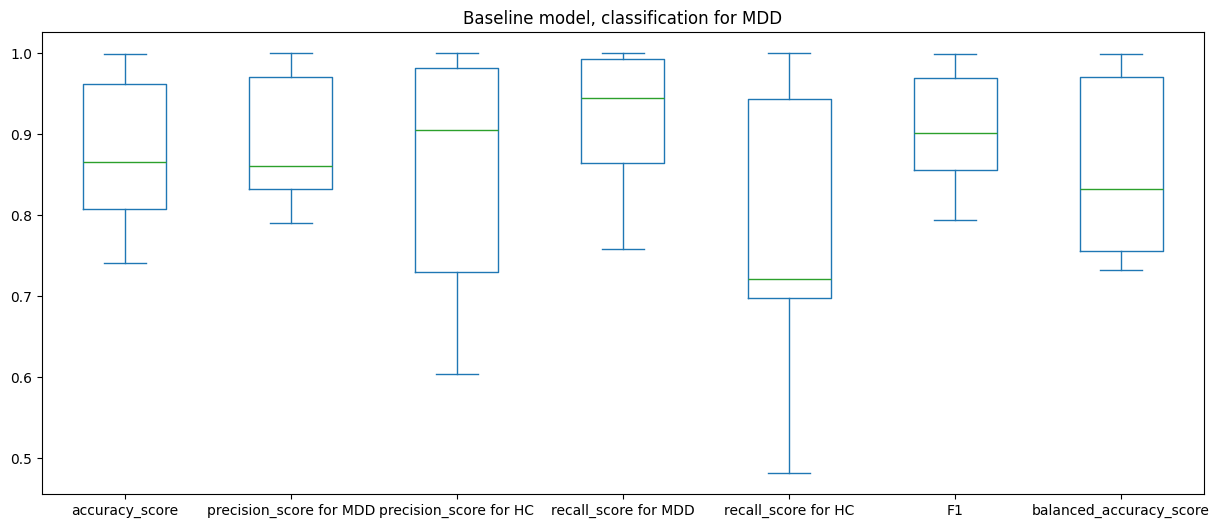

In [20]:
validation_metrics_a = pd.DataFrame(validation_metrics, columns=['accuracy_score', 'precision_score for MDD', 'precision_score for HC', 'recall_score for MDD', 'recall_score for HC', 'F1', 'balanced_accuracy_score'])

validation_metrics_a.plot(kind='box', title='Baseline model, classification for MDD', figsize=(15, 6))

In [5]:
class ChannelDropout(nn.Module):
    def __init__(self, rate, noise_shape=None, seed=None):
        super().__init__()
        self.rate = min(1., max(0., rate))
        self.noise_shape = noise_shape
        self.seed = seed
        if seed is not None:
            torch.manual_seed(seed)

    def forward(self, inputs):
        if self.training:
            noise_shape = [1, 1, inputs.shape[2]]
            mask = torch.bernoulli(torch.full(noise_shape, 1 - self.rate)).to(inputs.device)
            mask = mask.expand_as(inputs)
            return inputs * mask / (1 - self.rate)
        else:
            return inputs

    def extra_repr(self):
        return f'rate={self.rate}, noise_shape={self.noise_shape}, seed={self.seed}'
    

class ModelMDD(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.n_features = 19
        self.n_points = 3000

        self.channel_dropout = ChannelDropout(rate=0.25)
        
        # Conv1D layers
        self.conv1 = nn.Conv1d(self.n_features, 5, kernel_size=10, stride=1, padding=0)
        self.conv2 = nn.Conv1d(5, 10, kernel_size=10, stride=1, padding=0)
        self.conv3 = nn.Conv1d(10, 10, kernel_size=10, stride=1, padding=0)
        self.conv4 = nn.Conv1d(10, 15, kernel_size=5, stride=1, padding=0)
        
        # BatchNorm layers
        self.bn1 = nn.BatchNorm1d(5)
        self.bn2 = nn.BatchNorm1d(10)
        self.bn3 = nn.BatchNorm1d(10)
        self.bn4 = nn.BatchNorm1d(15)

        # BatchNorm layers
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(64)
        
        # Dense layers
        self.fc1 = nn.Linear(15 * 181, 256)  # 184 is calculated based on the input size and conv/pool operations
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)
        
        self.dropout = nn.AlphaDropout(dropout)
        
    def forward(self, x):
        # channel dropout
        x = self.channel_dropout(x)

        # Conv layers
        x = F.elu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = self.bn1(x)
        
        x = F.elu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = self.bn2(x)
        
        x = F.elu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        x = self.bn3(x)
        
        x = F.elu(self.conv4(x))
        x = F.max_pool1d(x, 2)
        x = self.bn4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense layers
        x = self.dropout(x)
        x = F.elu(self.fc_bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.elu(self.fc_bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x) # F.softmax(, dim=1)
        
        return x
    
def get_model_pretrain(dropout=0.5):
    model = ModelMDD(dropout)
    return model



In [6]:
def train_model_standard(model, X_train, y_train, X_val, y_val, file_path, class_weights):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Convert data to PyTorch tensors
    X_train = torch.FloatTensor(X_train).permute(0, 2, 1).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_val = torch.FloatTensor(X_val).permute(0, 2, 1).to(device)
    y_val = torch.LongTensor(y_val).to(device)

    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.00075)

    # Training loop
    best_val_acc = 0
    patience = 10
    patience_counter = 0
    epochs = 35
    history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        train_acc = train_correct / train_total
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        val_acc = val_correct / val_total
        val_loss /= len(val_loader)

        history['loss'].append(train_loss)
        history['acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # if val_acc > best_val_acc:
        #     best_val_acc = val_acc
        #     torch.save(model.state_dict(), file_path)
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping")
        #         break
    
    torch.save(model.state_dict(), file_path)
    return model, history


In [8]:
# MODEL B

# froze the convolutional layer weights
# removed the channel dropout layer

def freeze_layer(layer):
    for par in layer.parameters():
        par.require_grad = False
    return layer

def get_model_b():
    state_dict = torch.load('sleep_pretrain.pt', map_location=torch.device('cuda'))
    model_pretrain = get_model_pretrain()
    model_pretrain.load_state_dict(state_dict)
    model_pretrain.train()

    model_pretrain.channel_dropout = nn.Identity()
    model_pretrain.conv1 = freeze_layer(model_pretrain.conv1)
    model_pretrain.conv2 = freeze_layer(model_pretrain.conv2)
    model_pretrain.conv3 = freeze_layer(model_pretrain.conv3)
    model_pretrain.conv4 = freeze_layer(model_pretrain.conv4)

    model_pretrain.fc3 = nn.Linear(64, 2)
    return model_pretrain

# Main loop
torch.manual_seed(41)
np.random.seed(41)

testing_metrics = []
validation_metrics = []

n_timesteps = 3000
n_features = 19

val_loss = []
train_loss = []
val_acc = []
train_acc = []

gss = GroupShuffleSplit(n_splits=25, train_size=0.9, random_state=3)

device = 'cuda'

for i, (tv_idx, test_idx) in enumerate(gss.split(data, labels, groups)):
    print(i)

    X_train_val = data[tv_idx]
    y_train_val = labels[tv_idx]

    X_test = data[test_idx]
    y_test = labels[test_idx]

    group = groups[tv_idx]
    gss_train_val = GroupShuffleSplit(n_splits=1, train_size=0.83, random_state=3)
    for train_idx, val_idx in gss_train_val.split(X_train_val, y_train_val, group):


        X_train = X_train_val[train_idx]
        y_train = y_train_val[train_idx]
        
        X_val = X_train_val[val_idx]
        y_val = y_train_val[val_idx]
        
        # Data Augmentation
        X_train = np.vstack((X_train, X_train + np.random.normal(loc=0, scale=0.7, size=X_train.shape)))
        y_train = np.hstack((y_train, y_train))

        
        model = get_model_b()
        file_path = f"{base}/baseline_ckpt/model_b_seed3_fold{i}.pth"
        
        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        
        model, history = train_model_standard(model, X_train, y_train, X_val, y_val, file_path, class_weights)
        
        val_loss.append(history['val_loss'])
        train_loss.append(history['loss'])
        val_acc.append(history['val_acc'])
        train_acc.append(history['acc'])
        
        model.load_state_dict(torch.load(file_path))
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            preds = torch.argmax(model(X_test_tensor.permute(0, 2, 1)), dim=1).cpu().numpy()

        testing_metrics.append([
            accuracy_score(y_test, preds),
            precision_score(y_test, preds, pos_label=1),
            precision_score(y_test, preds, pos_label=0),
            recall_score(y_test, preds, pos_label=1),
            recall_score(y_test, preds, pos_label=0),
            f1_score(y_test, preds),
            balanced_accuracy_score(y_test, preds)
        ])
        
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            preds_val = torch.argmax(model(X_val_tensor.permute(0, 2, 1)), dim=1).cpu().numpy()

        validation_metrics.append([
            accuracy_score(y_val, preds_val),
            precision_score(y_val, preds_val, pos_label=1),
            precision_score(y_val, preds_val, pos_label=0),
            recall_score(y_val, preds_val, pos_label=1),
            recall_score(y_val, preds_val, pos_label=0),
            f1_score(y_val, preds_val),
            balanced_accuracy_score(y_val, preds_val)
        ])

        print('test:', testing_metrics[-1], 'val:', validation_metrics[-1])

results_filename = f"{base}/model_b_25_seed3.mat"
savemat(results_filename, {"validation_metrics": validation_metrics, "testing_metrics": testing_metrics})


0


test: [0.8956228956228957, 1.0, 0.8355437665782494, 0.7777777777777778, 1.0, 0.875, 0.8888888888888888] val: [0.6758304696449027, 1.0, 0.5170648464163823, 0.5035087719298246, 1.0, 0.6697782963827305, 0.7517543859649123]
1
test: [0.8619528619528619, 0.6985294117647058, 1.0, 1.0, 0.7970297029702971, 0.8225108225108225, 0.8985148514851485] val: [0.8130081300813008, 1.0, 0.6530172413793104, 0.7114695340501792, 1.0, 0.831413612565445, 0.8557347670250897]
2
test: [0.8264604810996563, 1.0, 0.7423469387755102, 0.6529209621993127, 1.0, 0.7900207900207901, 0.8264604810996563] val: [0.7971014492753623, 1.0, 0.6424361493123772, 0.6807017543859649, 1.0, 0.8100208768267223, 0.8403508771929824]
3
test: [0.7277227722772277, 1.0, 0.7100175746924429, 0.18316831683168316, 1.0, 0.30962343096234307, 0.5915841584158416] val: [0.7813620071684588, 0.9526184538653366, 0.6238532110091743, 0.6996336996336996, 0.9347079037800687, 0.8067581837381204, 0.8171708017068842]
4
test: [0.8298245614035088, 1.0, 0.7575, 0.

<Axes: title={'center': 'Model B, classification for MDD'}>

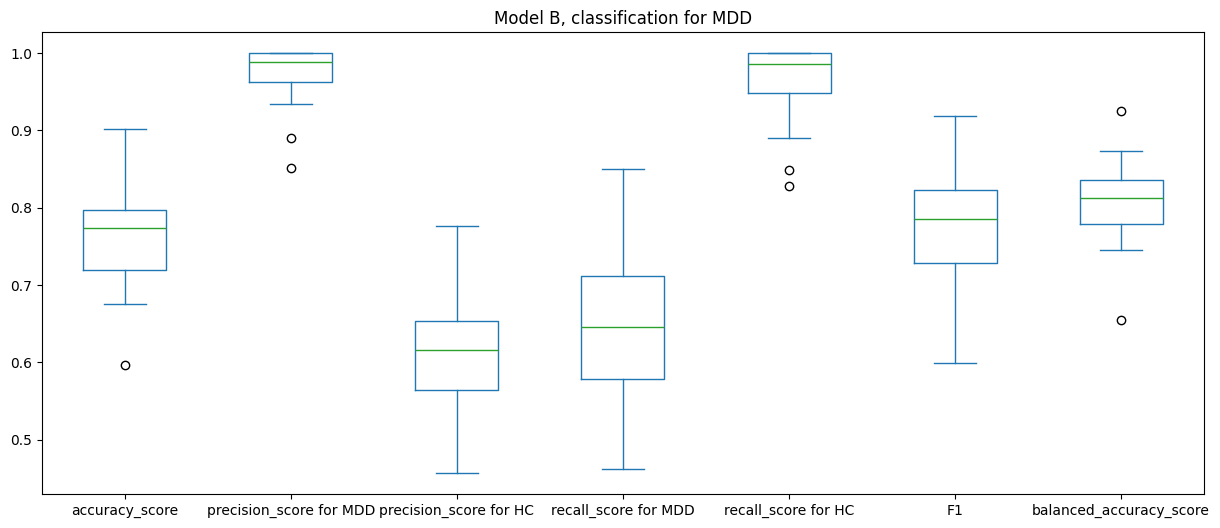

In [11]:
results_b = pd.DataFrame(validation_metrics, columns=['accuracy_score', 'precision_score for MDD', 'precision_score for HC', 'recall_score for MDD', 'recall_score for HC', 'F1', 'balanced_accuracy_score'])

results_b.plot(kind='box', title='Model B, classification for MDD', figsize=(15, 6))

In [13]:
# MODEL B

# froze the convolutional layer weights
# removed the channel dropout layer

def unfreeze_layer(layer):
    for par in layer.parameters():
        par.require_grad = True
    return layer

def get_model_c(fold):
    state_dict = torch.load(f'baseline_ckpt/model_b_seed3_fold{fold}.pth', map_location=torch.device('cuda'))
    model_pretrain = model
    model_pretrain.load_state_dict(state_dict)
    model_pretrain.train()

    model_pretrain.conv1 = unfreeze_layer(model_pretrain.conv1)
    model_pretrain.conv2 = unfreeze_layer(model_pretrain.conv2)
    model_pretrain.conv3 = unfreeze_layer(model_pretrain.conv3)
    model_pretrain.conv4 = unfreeze_layer(model_pretrain.conv4)

    return model_pretrain

# Main loop
torch.manual_seed(41)
np.random.seed(41)

testing_metrics = []
validation_metrics = []

n_timesteps = 3000
n_features = 19

val_loss = []
train_loss = []
val_acc = []
train_acc = []

gss = GroupShuffleSplit(n_splits=25, train_size=0.9, random_state=3)

device = 'cuda'

for i, (tv_idx, test_idx) in enumerate(gss.split(data, labels, groups)):
    print(i)

    X_train_val = data[tv_idx]
    y_train_val = labels[tv_idx]

    X_test = data[test_idx]
    y_test = labels[test_idx]

    group = groups[tv_idx]
    gss_train_val = GroupShuffleSplit(n_splits=1, train_size=0.83, random_state=3)
    for train_idx, val_idx in gss_train_val.split(X_train_val, y_train_val, group):


        X_train = X_train_val[train_idx]
        y_train = y_train_val[train_idx]
        
        X_val = X_train_val[val_idx]
        y_val = y_train_val[val_idx]
        
        # Data Augmentation
        X_train = np.vstack((X_train, X_train + np.random.normal(loc=0, scale=0.7, size=X_train.shape)))
        y_train = np.hstack((y_train, y_train))

        
        model = get_model_c(i)
        file_path = f"{base}/baseline_ckpt/model_c_seed3_fold{i}.pth"
        
        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        
        model, history = train_model_standard(model, X_train, y_train, X_val, y_val, file_path, class_weights)
        
        val_loss.append(history['val_loss'])
        train_loss.append(history['loss'])
        val_acc.append(history['val_acc'])
        train_acc.append(history['acc'])
        
        model.load_state_dict(torch.load(file_path))
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            preds = torch.argmax(model(X_test_tensor.permute(0, 2, 1)), dim=1).cpu().numpy()

        testing_metrics.append([
            accuracy_score(y_test, preds),
            precision_score(y_test, preds, pos_label=1),
            precision_score(y_test, preds, pos_label=0),
            recall_score(y_test, preds, pos_label=1),
            recall_score(y_test, preds, pos_label=0),
            f1_score(y_test, preds),
            balanced_accuracy_score(y_test, preds)
        ])
        
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            preds_val = torch.argmax(model(X_val_tensor.permute(0, 2, 1)), dim=1).cpu().numpy()

        validation_metrics.append([
            accuracy_score(y_val, preds_val),
            precision_score(y_val, preds_val, pos_label=1),
            precision_score(y_val, preds_val, pos_label=0),
            recall_score(y_val, preds_val, pos_label=1),
            recall_score(y_val, preds_val, pos_label=0),
            f1_score(y_val, preds_val),
            balanced_accuracy_score(y_val, preds_val)
        ])

        print('test:', testing_metrics[-1], 'val:', validation_metrics[-1])

results_filename = f"{base}/model_c_25_seed3.mat"
savemat(results_filename, {"validation_metrics": validation_metrics, "testing_metrics": testing_metrics})

0
test: [0.8249158249158249, 1.0, 0.7517899761336515, 0.6272401433691757, 1.0, 0.7709251101321586, 0.8136200716845878] val: [0.6517754868270332, 1.0, 0.49917627677100496, 0.4666666666666667, 1.0, 0.6363636363636364, 0.7333333333333334]
1
test: [0.7474747474747475, 0.5588235294117647, 1.0, 1.0, 0.6287128712871287, 0.7169811320754716, 0.8143564356435644] val: [0.8420441347270615, 1.0, 0.6902050113895216, 0.7562724014336918, 1.0, 0.8612244897959184, 0.8781362007168458]
2
test: [0.8264604810996563, 1.0, 0.7423469387755102, 0.6529209621993127, 1.0, 0.7900207900207901, 0.8264604810996563] val: [0.7736900780379041, 1.0, 0.6169811320754717, 0.643859649122807, 1.0, 0.7833511205976521, 0.8219298245614035]
3
test: [0.7475247524752475, 0.7951807228915663, 0.739961759082218, 0.32673267326732675, 0.9579207920792079, 0.4631578947368421, 0.6423267326732673] val: [0.7801672640382318, 0.9763157894736842, 0.6170678336980306, 0.6794871794871795, 0.9690721649484536, 0.8012958963282938, 0.8242796722178165]


<Axes: title={'center': 'Model C, classification for MDD'}>

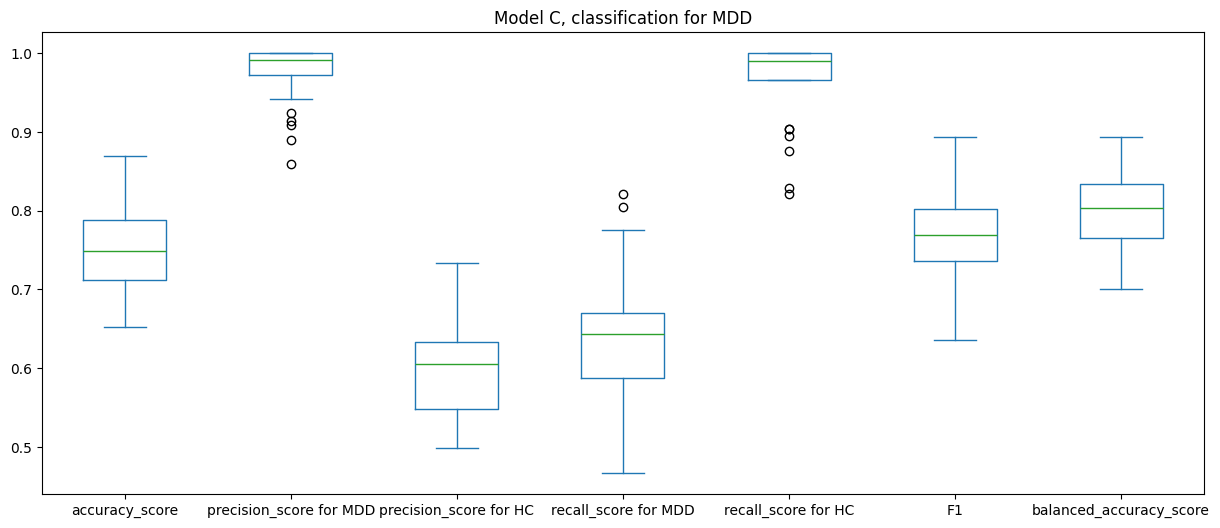

In [14]:
results_c = pd.DataFrame(validation_metrics, columns=['accuracy_score', 'precision_score for MDD', 'precision_score for HC', 'recall_score for MDD', 'recall_score for HC', 'F1', 'balanced_accuracy_score'])

results_c.plot(kind='box', title='Model C, classification for MDD', figsize=(15, 6))

<Axes: >

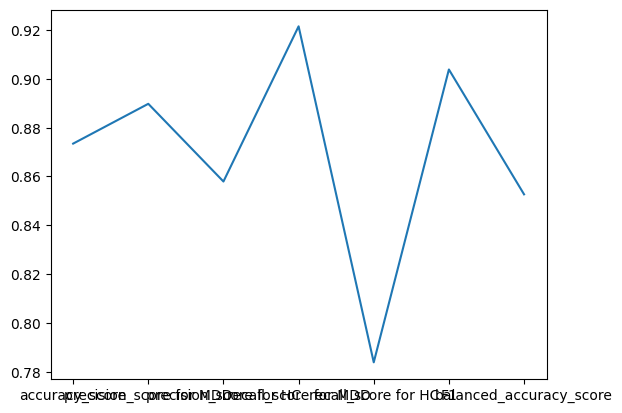

In [30]:
validation_metrics_a.mean().plot()

In [37]:
validation_metrics_a.mean()

accuracy_score             0.873446
precision_score for MDD    0.889741
precision_score for HC     0.857939
recall_score for MDD       0.921448
recall_score for HC        0.783926
F1                         0.903787
balanced_accuracy_score    0.852687
dtype: float64

In [61]:
# MODEL d

# froze the convolutional layer weights
# removed the channel dropout layer

def get_model_d():
    state_dict = torch.load('sleep_pretrain.pt', map_location=torch.device('cuda'))
    model_pretrain = get_model_pretrain()
    model_pretrain.load_state_dict(state_dict)
    model_pretrain.train()

    model_pretrain.channel_dropout = nn.Identity()

    model_pretrain.fc3 = nn.Linear(64, 2)
    return model_pretrain

# Main loop
torch.manual_seed(41)
np.random.seed(41)

testing_metrics = []
validation_metrics = []

n_timesteps = 3000
n_features = 19

val_loss = []
train_loss = []
val_acc = []
train_acc = []

gss = GroupShuffleSplit(n_splits=25, train_size=0.9, random_state=3)

device = 'cuda'

for i, (tv_idx, test_idx) in enumerate(gss.split(data, labels, groups)):
    print(i)

    X_train_val = data[tv_idx]
    y_train_val = labels[tv_idx]

    X_test = data[test_idx]
    y_test = labels[test_idx]

    group = groups[tv_idx]
    gss_train_val = GroupShuffleSplit(n_splits=1, train_size=0.83, random_state=3)
    for train_idx, val_idx in gss_train_val.split(X_train_val, y_train_val, group):


        X_train = X_train_val[train_idx]
        y_train = y_train_val[train_idx]
        
        X_val = X_train_val[val_idx]
        y_val = y_train_val[val_idx]
        
        # Data Augmentation
        X_train = np.vstack((X_train, X_train + np.random.normal(loc=0, scale=0.7, size=X_train.shape)))
        y_train = np.hstack((y_train, y_train))

        
        model = get_model_d()
        file_path = f"{base}/baseline_ckpt/model_d_seed3_fold{i}.pth"
        
        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        
        model, history = train_model_standard(model, X_train, y_train, X_val, y_val, file_path, class_weights)
        
        val_loss.append(history['val_loss'])
        train_loss.append(history['loss'])
        val_acc.append(history['val_acc'])
        train_acc.append(history['acc'])
        
        model.load_state_dict(torch.load(file_path))
        model = model.to(device)
        model.eval()

        with torch.no_grad():
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            preds = torch.argmax(model(X_test_tensor.permute(0, 2, 1)), dim=1).cpu().numpy()

        testing_metrics.append([
            accuracy_score(y_test, preds),
            precision_score(y_test, preds, pos_label=1),
            precision_score(y_test, preds, pos_label=0),
            recall_score(y_test, preds, pos_label=1),
            recall_score(y_test, preds, pos_label=0),
            f1_score(y_test, preds),
            balanced_accuracy_score(y_test, preds)
        ])
        
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            preds_val = torch.argmax(model(X_val_tensor.permute(0, 2, 1)), dim=1).cpu().numpy()

        validation_metrics.append([
            accuracy_score(y_val, preds_val),
            precision_score(y_val, preds_val, pos_label=1),
            precision_score(y_val, preds_val, pos_label=0),
            recall_score(y_val, preds_val, pos_label=1),
            recall_score(y_val, preds_val, pos_label=0),
            f1_score(y_val, preds_val),
            balanced_accuracy_score(y_val, preds_val)
        ])

        print('test:', testing_metrics[-1], 'val:', validation_metrics[-1])

results_filename = f"{base}/model_d_25_seed3.mat"
savemat(results_filename, {"validation_metrics": validation_metrics, "testing_metrics": testing_metrics})

0
test: [0.8956228956228957, 1.0, 0.8355437665782494, 0.7777777777777778, 1.0, 0.875, 0.8888888888888888] val: [0.6758304696449027, 1.0, 0.5170648464163823, 0.5035087719298246, 1.0, 0.6697782963827305, 0.7517543859649123]
1
test: [0.8653198653198653, 0.7037037037037037, 1.0, 1.0, 0.801980198019802, 0.8260869565217391, 0.900990099009901] val: [0.8130081300813008, 1.0, 0.6530172413793104, 0.7114695340501792, 1.0, 0.831413612565445, 0.8557347670250897]
2
test: [0.8264604810996563, 1.0, 0.7423469387755102, 0.6529209621993127, 1.0, 0.7900207900207901, 0.8264604810996563] val: [0.7971014492753623, 1.0, 0.6424361493123772, 0.6807017543859649, 1.0, 0.8100208768267223, 0.8403508771929824]
3
test: [0.7277227722772277, 1.0, 0.7100175746924429, 0.18316831683168316, 1.0, 0.30962343096234307, 0.5915841584158416] val: [0.7789725209080047, 0.9523809523809523, 0.6210045662100456, 0.6959706959706959, 0.9347079037800687, 0.8042328042328042, 0.8153392998753823]
4
test: [0.8298245614035088, 1.0, 0.7575, 0.

<Axes: title={'center': 'Model D, classification for MDD'}>

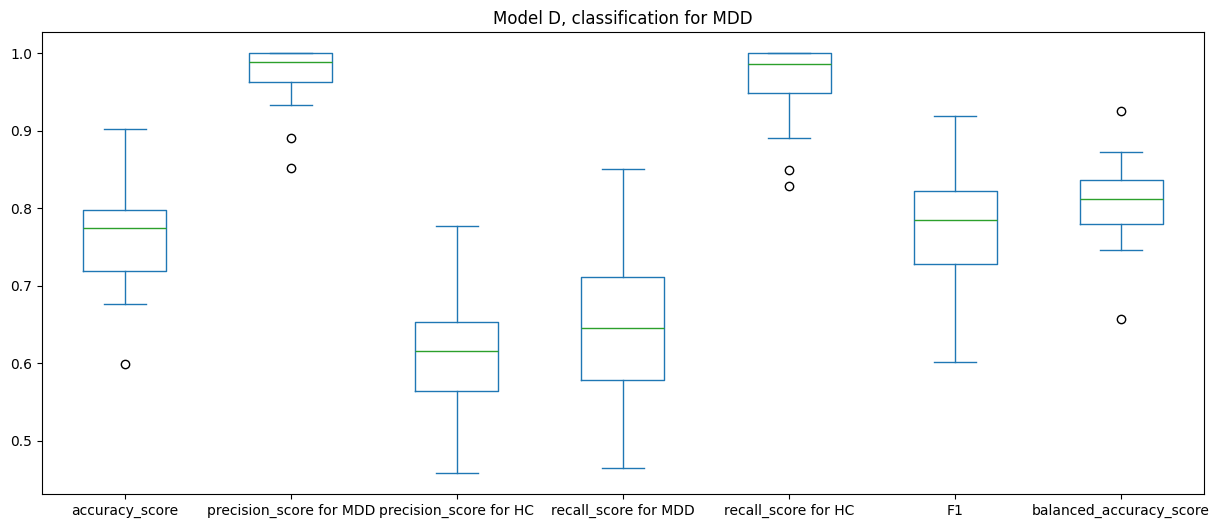

In [62]:
results_d = pd.DataFrame(validation_metrics, columns=['accuracy_score', 'precision_score for MDD', 'precision_score for HC', 'recall_score for MDD', 'recall_score for HC', 'F1', 'balanced_accuracy_score'])

results_d.plot(kind='box', title='Model D, classification for MDD', figsize=(15, 6))

In [102]:
results_d

,accuracy_score,precision_score for MDD,precision_score for HC,recall_score for MDD,recall_score for HC,F1,balanced_accuracy_score
0,0.675830,1.000000,0.517065,0.503509,1.000000,0.669778,0.751754
1,0.813008,1.000000,0.653017,0.711470,1.000000,0.831414,0.855735
2,0.797101,1.000000,0.642436,0.680702,1.000000,0.810021,0.840351
3,0.778973,0.952381,0.621005,0.695971,0.934708,0.804233,0.815339
4,0.716137,0.981763,0.548077,0.578853,0.979381,0.728298,0.779117
5,0.788530,1.000000,0.631250,0.668539,1.000000,0.801347,0.834270
6,0.845528,0.967880,0.700508,0.792982,0.948454,0.871745,0.870718
7,0.749164,1.000000,0.592391,0.605263,1.000000,0.754098,0.802632
8,0.719064,1.000000,0.564767,0.557895,1.000000,0.716216,0.778947
9,0.838350,1.000000,0.692797,0.745614,1.000000,0.854271,0.872807


[[<matplotlib.axis.XTick at 0x7f01f306f340>,
 [Text(1, 0, 'accuracy_score'),
  Text(2, 0, 'precision_score for MDD'),
  Text(3, 0, 'precision_score for HC'),
  Text(4, 0, 'recall_score for MDD'),
  Text(5, 0, 'recall_score for HC'),
  Text(6, 0, 'F1'),
  Text(7, 0, 'balanced_accuracy_score')]]

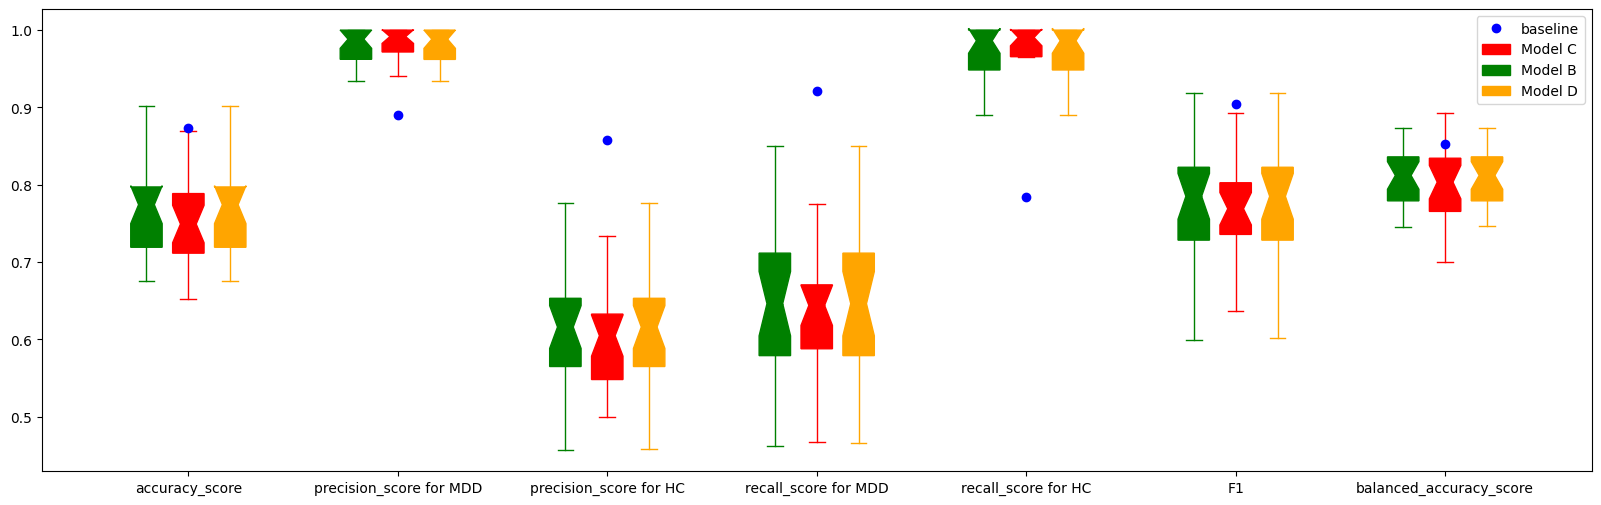

In [117]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 6))

positions=[x for x in range(1, 8)]
for x, pos in zip(results_c.columns, positions):
    c='red'
    c_plt = ax.boxplot(results_c[x], positions=[pos], showfliers=False, notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
    c='green'
    b_plt = ax.boxplot(results_b[x], positions=[pos - 0.2], showfliers=False, notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
    c='orange'
    d_plt = ax.boxplot(results_d[x], positions=[pos + 0.2], showfliers=False, notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))

# plt.axis('off')

for i, x in enumerate(validation_metrics_a.mean()):
    if i == 0:
        ax.plot(i+1, x, 'bo', label='baseline')
    else:
        ax.plot(i+1, x, 'bo')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Model C')
red_patch = mpatches.Patch(color='red', label='Model C')
green_patch = mpatches.Patch(color='green', label='Model B')
oragne_patch = mpatches.Patch(color='orange', label='Model D')

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([red_patch, green_patch, oragne_patch])

plt.legend(handles=handles)

ax.set(xticks=positions, xticklabels=list(results_c.columns))

In [93]:
ax.get_xaxis()